# Automatic num_feature selection techniques

In [8]:
from probatus.feature_elimination import ShapRFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

### Basic example of ShapRFECV

In [10]:
# Simple ShapRFECV example
X, y = make_classification(n_samples=1000, n_informative=20, n_features=100)
clf = CatBoostClassifier(n_estimators=1000, verbose=0)
shap_elimination = ShapRFECV(clf, step=0.2, min_features_to_select=5, cv=5, scoring="f1")
report = shap_elimination.fit_compute(X, y)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [15]:
# Inspect the report generated by ShapRFECV
# Can you find the best iteration? Look at `train_metric_mean`.
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,100,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[95, 39, 36, 75, 91, 5, 86, 44, 93, 38, 58, 88...",1.000,0.000,0.893,0.029
2,80,"[0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 16, 1...","[8, 47, 83, 25, 70, 35, 10, 32, 37, 14, 85, 61...",1.000,0.000,0.887,0.025
3,64,"[0, 1, 3, 4, 6, 7, 9, 11, 13, 16, 17, 18, 19, ...","[76, 3, 71, 24, 52, 22, 4, 11, 31, 73, 40, 94]",1.000,0.000,0.898,0.027
4,52,"[0, 1, 6, 7, 9, 13, 16, 17, 18, 19, 20, 21, 23...","[42, 67, 43, 78, 20, 72, 21, 59, 23, 50]",1.000,0.000,0.906,0.019
5,42,"[0, 1, 6, 7, 9, 13, 16, 17, 18, 19, 26, 27, 28...","[79, 82, 18, 49, 9, 57, 30, 80]",1.000,0.001,0.916,0.021
6,34,"[0, 1, 6, 7, 13, 16, 17, 19, 26, 27, 28, 33, 3...","[56, 26, 74, 99, 87, 6]",1.000,0.001,0.918,0.021
7,28,"[0, 1, 7, 13, 16, 17, 19, 27, 28, 33, 34, 41, ...","[53, 60, 1, 41, 90]",0.999,0.000,0.919,0.013
8,23,"[0, 7, 13, 16, 17, 19, 27, 28, 33, 34, 45, 46,...","[68, 17, 27, 51]",0.999,0.000,0.921,0.016
9,19,"[0, 7, 13, 16, 19, 28, 33, 34, 45, 46, 48, 54,...","[45, 13, 81]",0.998,0.001,0.912,0.017
10,16,"[0, 7, 16, 19, 28, 33, 34, 46, 48, 54, 55, 64,...","[54, 16, 46]",0.998,0.001,0.906,0.024


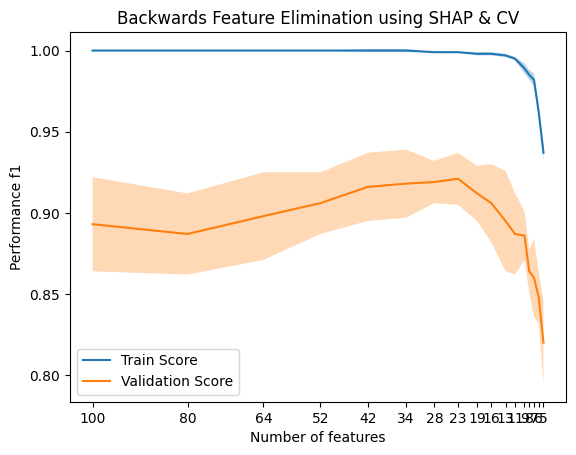

<AxesSubplot: title={'center': 'Backwards Feature Elimination using SHAP & CV'}, xlabel='Number of features', ylabel='Performance f1'>

In [17]:
# We can visually inspect the report and try identify the best iteration
shap_elimination.plot()

In [16]:
# Once we have identified which iteration was best, we can get the feature names by:
shap_elimination.get_reduced_features_set(num_features=23)

array([ 0,  7, 13, 16, 17, 19, 27, 28, 33, 34, 45, 46, 48, 51, 54, 55, 64,
       68, 69, 77, 81, 96, 98])

# But, is there a more automated way of selecting "best" features?

Yes, probatus support a few strategies for selecting the best `num_features` for your needs.

Before we jump into these automated techniques, there are a number of factors you might want to consider when selecting the best iteration:
1. **Model performance score:** Most people will care about this the most. You'll try to maximize a score like f1 or accuracy or ROC_AUC. But there are more factors to consider...
2. **Variance of model performance:** If your model performance scores vary considerably across cross validation folds, it might be a sign that your model is not generalizing well. Some people may want to ensure model performance standard deviation is also minimized.
3. **Number of features:** You might want to keep the number of features to a minimum (smaller model, siplier data pipeline, easier to explain model)

To accomodate some of the above needs, probatus supports automated strategies to select the best "num_features". Strategies supported are:
1. **num_features="best":** If what you care about is maximizing `val_metric_mean` (model performance score), this strategy is for you.
2. **num_features="best_coherent":** If you care about high model performance whilst also minimizing variation of model performance between cross validation folds, this strategy is for you.
3. **num_features="best_parsimonious":** If you care about high model performance whilst also minimizing the number of features selected, this model is for you.

In [21]:
# Best
best_features = shap_elimination.get_reduced_features_set(num_features="best")
print(f"The {len(best_features)} best features are: {best_features}")

The 23 best features are: [ 0  7 13 16 17 19 27 28 33 34 45 46 48 51 54 55 64 68 69 77 81 96 98]


In [24]:
# Best coherent
best_features = shap_elimination.get_reduced_features_set(num_features="best_coherent")
print(f"The {len(best_features)} best coherent features are: {best_features}")

The 28 best coherent features are: [ 0  1  7 13 16 17 19 27 28 33 34 41 45 46 48 51 53 54 55 60 64 68 69 77
 81 90 96 98]


In [25]:
# Best parsimonious
best_features = shap_elimination.get_reduced_features_set(num_features="best_parsimonious")
print(f"The {len(best_features)} best parsimonious features are: {best_features}")

The 16 best parsimonious features are: [ 0  7 16 19 28 33 34 46 48 54 55 64 69 77 96 98]


In [27]:
# Note, you can change the behavior of `best_coherent` and `best_parsimonious` by changing the `standard_error_threshold` parameter
# Best coherent (standard_error_threshold=0.5)
best_features = shap_elimination.get_reduced_features_set(
    num_features="best_parsimonious", standard_error_threshold=0.5
)
print(f"The {len(best_features)} best coherent features are: {best_features}")

The 23 best coherent features are: [ 0  7 13 16 17 19 27 28 33 34 45 46 48 51 54 55 64 68 69 77 81 96 98]


# Support & Ranking
In alignment with the sklearn implementation of RFECV, you can get `support` and `ranking` output from ShapRFECV. 

In [28]:
# Get support (boolean mask of X feature columns)
best_features = shap_elimination.get_reduced_features_set(num_features="best", return_type="feature_names")
best_features_support = shap_elimination.get_reduced_features_set(num_features="best", return_type="support")
best_features_ranking = shap_elimination.get_reduced_features_set(num_features="best", return_type="ranking")
print(f"The {len(best_features)} best features are: {best_features}")
print(f"Support boolean mask: {best_features_support}")
print(f"Ranking: {best_features_ranking}")

The 23 best features are: [ 0  7 13 16 17 19 27 28 33 34 45 46 48 51 54 55 64 68 69 77 81 96 98]
Support boolean mask: [True, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, True, False, True, False, False, False, False, False, False, False, True, True, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, True, False, False, False, True, True, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False]
Ranking: [8, 21, 91, 49, 54, 81, 29, 0, 60, 34, 66, 55, 92, 13, 69, 90, 10, 16, 32, 7, 42, 44, 53, 46, 51, 63, 25, 17, 0, 89, 36, 56, 67, 2, 0, 65, 78, 68, 85, 77, 58, 22, 38, 40, 83, 12, 11, 61, 4, 33, 